## OLS Classification on Randomly Generated Data

In this notebook, we use Ordinary Least Squares to carry out classification on a randomly generated data set.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import io

[[ 0.15  0.1 ]
 [ 0.1   0.15]]
(200, 2)
(200, 2)


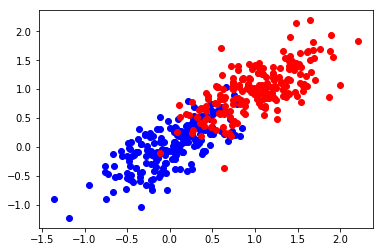

In [2]:
### Ordinary Least Squares
### SOLVES 2-CLASS LEAST SQUARES PROBLEM

### LOAD DATA ###
### IF LoadClasses IS True, THEN LOAD DATA FROM FILES ###
### OTHERSIE, RANDOMLY GENERATE DATA ###
LoadClasses    = False
TrainOutliers  = False
TestOutliers   = False
NOut           = 20
NSampsClass    = 200
NSamps         = 2*NSampsClass

if LoadClasses:
    
    ### GET FILENAMES %%%
    ### THESE ARE THE OPTIONS ###
    ### LinSepC1, LinSepC2,LinSepC2Outlier (Still Linearly Separable) ###
    ### NonLinSepC1, NonLinSepC2, NonLinSepC22 ###
    
    InFile1          = '../data/PaulGader/LinSepC1.mat'
    InFile2          = '../data/PaulGader/LinSepC2.mat' #Change to LinSepC2Outlier
    C1Dict           = io.loadmat(InFile1)
    C2Dict           = io.loadmat(InFile2)
    C1               = C1Dict['LinSepC1']
    C2               = C2Dict['LinSepC2']
    
    if TrainOutliers:
        ### Let's Make Some Noise ###
        Out1        = 2*np.random.rand(NOut,2)-0.5
        Out2        = 2*np.random.rand(NOut,2)-0.5
        C1          = np.concatenate((C1,Out1),axis=0)
        C2          = np.concatenate((C2,Out2),axis=0)
        NSampsClass = NSampsClass+NOut
        NSamps      = 2*NSampsClass
else:
    ### Randomly Generate Some Data
    ### Make a covariance using a diagonal array and rotation matrix
    pi      = 3.141592653589793
    Lambda1 = 0.25
    Lambda2 = 0.05
    DiagMat = np.array([[Lambda1, 0.0],[0.0, Lambda2]])
    RotMat  = np.array([[np.sin(pi/4), np.cos(pi/4)], [-np.cos(pi/4), np.sin(pi/4)]])
    mu1     = np.array([0,0])
    mu2     = np.array([1,1])
    Sigma   = np.dot(np.dot(RotMat.T, DiagMat), RotMat)
    C1      = np.random.multivariate_normal(mu1, Sigma, NSampsClass) #generate training sets
    C2      = np.random.multivariate_normal(mu2, Sigma, NSampsClass)
    #to generate a test set, repeat lines defining C1, C2 many times from same distribution
    #generate AllSamps 
    #
    
    print(Sigma)
    print(C1.shape)
    print(C2.shape)

### PLOT DATA ###
plt.figure(1)
plt.plot(C1[:NSampsClass, 0], C1[:NSampsClass, 1], 'bo')
plt.plot(C2[:NSampsClass, 0], C2[:NSampsClass, 1], 'ro')
plt.show()

Set up target outputs and plot:

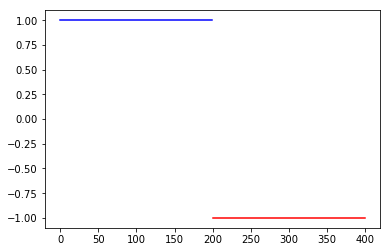

In [3]:
### SET UP TARGET OUTPUTS ###
TargetOutputs          = np.ones((NSamps,1)) #Set 1st half (400 values) to 1s
TargetOutputs[NSampsClass:NSamps] = -TargetOutputs[NSampsClass:NSamps] 
#Set 2nd half to -1s (now 1st 200 are 1, 2nd 200 are -1)

### PLOT TARGET OUTPUTS ###
plt.figure(2)
plt.plot(range(NSampsClass),         TargetOutputs[range(NSampsClass)],   'b-')
plt.plot(range(NSampsClass, NSamps), TargetOutputs[range(NSampsClass, NSamps)], 'r-')
plt.show()

Calculate the least squares solutions using Ordinary Least Squares Solution:
$$ w = (X^TX)X-Ty $$

In [4]:
### FIND LEAST SQUARES SOLUTION ###
AllSamps     = np.concatenate((C1,C2),axis=0) #concatenate two classes into a single array 
#(before classes were separated into two arrays; axis tells you the way you are concatenating)

#add ones to last column -- this adds the y-intercept (i.e. shifts line up and down)
AllSampsBias = np.concatenate((AllSamps, np.ones((NSamps,1))), axis=1) 

#calculate pseudo-inverse
Pseudo       = linalg.pinv2(AllSampsBias)

#multipy pseudo-inverse by the target outputs to get the weighting factors
w            = Pseudo.dot(TargetOutputs) #weights (parameters you are trying to estimate)

In [5]:
# Display the shapes of the original samples and the concatenated ones:
print('C1 shape:',C1.shape)
print('C2 shape:',C2.shape)
print('AllSamps shape:',AllSamps.shape)
print('weighting factors:\n',w)

C1 shape: (200, 2)
C2 shape: (200, 2)
AllSamps shape: (400, 2)
weighting factors:
 [[-0.59095569]
 [-0.69307886]
 [ 0.65632439]]


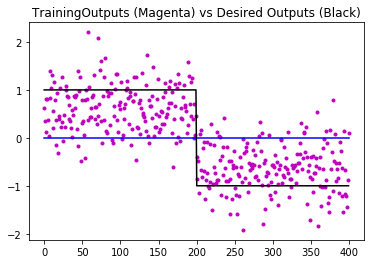

In [15]:
### COMPUTE OUTPUTS ON TRAINING DATA ###
y = AllSampsBias.dot(w) #calculate y from the least squares

### PLOT OUTPUTS FROM TRAINING DATA ###
plt.figure(3)
plt.plot(range(NSamps), y, 'm.')
plt.plot(range(NSamps),np.zeros((NSamps,1)), 'b') #Zero is the classification "threshold"
plt.plot(range(NSamps), TargetOutputs, 'k')
plt.title('TrainingOutputs (Magenta) vs Desired Outputs (Black)')
plt.show()

The line is the decision criteria for classification

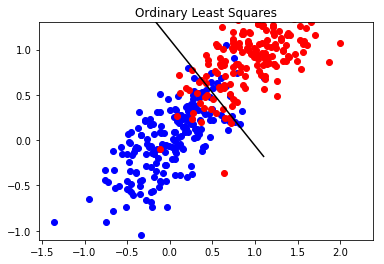

In [7]:
### CALCULATE AND PLOT LINEAR DISCRIMINANT ###
Slope     = -w[1]/w[0]
Intercept = -w[2]/w[0]
Domain    = np.linspace(-1.1, 1.1, 60) #Tile the decision surface over the range
Disc      = Slope*Domain+Intercept

plt.figure(4)
plt.plot(C1[:NSampsClass, 0], C1[:NSampsClass, 1], 'bo')
plt.plot(C2[:NSampsClass, 0], C2[:NSampsClass, 1], 'ro')
plt.plot(Domain, Disc, 'k-')
plt.ylim([-1.1,1.3])
plt.title('Ordinary Least Squares')
plt.show()

Ridge Regression -- Diagonally Load by adding $$\lambda

In [8]:
RegConst      = 0.1 #set lambda to 0.1
AllSampsBias  = np.concatenate((AllSamps, np.ones((NSamps,1))), axis=1)

#calculate transpose of matrix 
AllSampsBiasT = AllSampsBias.T

#multiply the transpose by the original matrix (XTX)
XtX           = AllSampsBiasT.dot(AllSampsBias)

#Add regularization constant term (lambda) 
AllSampsReg   = XtX + RegConst*np.eye(3) #np.eye(3) is the 3x3 identity matrix 
Pseudo        = linalg.pinv2(AllSampsReg) #take the pseudo-inverse
wr            = Pseudo.dot(AllSampsBiasT.dot(TargetOutputs)) #calculate ridge regression weights 

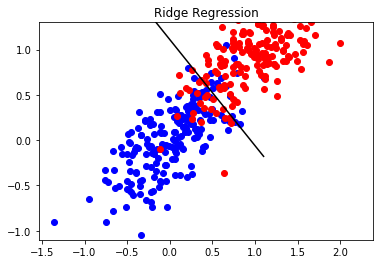

In [9]:
Slope     = -wr[1]/wr[0]
Intercept = -wr[2]/wr[0]
Domain    = np.linspace(-1.1, 1.1, 60)
Disc      = Slope*Domain+Intercept

matplotlib.pyplot.figure(5)
matplotlib.pyplot.plot(C1[:NSampsClass, 0], C1[:NSampsClass, 1], 'bo')
matplotlib.pyplot.plot(C2[:NSampsClass, 0], C2[:NSampsClass, 1], 'ro')
matplotlib.pyplot.plot(Domain, Disc, 'k-')
matplotlib.pyplot.ylim([-1.1,1.3])
matplotlib.pyplot.title('Ridge Regression')
matplotlib.pyplot.show()

Save this project with the name: OLSandRidgeRegress2DPGader.  Make a New Project for Spectra.

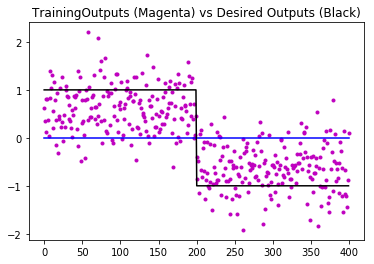

In [14]:
### COMPUTE OUTPUTS ON TRAINING DATA ###
yr = AllSampsBias.dot(wr)

### PLOT OUTPUTS FROM TRAINING DATA ###
matplotlib.pyplot.figure(6)
matplotlib.pyplot.plot(range(NSamps), yr, 'm.')
matplotlib.pyplot.plot(range(NSamps),np.zeros((NSamps,1)), 'b')
matplotlib.pyplot.plot(range(NSamps), TargetOutputs, 'k')
matplotlib.pyplot.title('TrainingOutputs (Magenta) vs Desired Outputs (Black)')
matplotlib.pyplot.show()

In [11]:
#Ordinary Least Squares
y1 = y[range(NSampsClass)]
y2 = y[range(NSampsClass, NSamps)]
Corr1 = np.sum([y1>0]) #of correctly classified points in first class
Corr2 = np.sum([y2<0]) #of correctly classified points in second class

#Ridge Regression
y1r = yr[range(NSampsClass)]
y2r = yr[range(NSampsClass, NSamps)]
Corr1r = np.sum([y1r>0])
Corr2r = np.sum([y2r<0])

In [12]:
print('Result for Ordinary Least Squares')
CorrClassRate=(Corr1+Corr2)/NSamps
print(Corr1 + Corr2, 'Correctly Classified for a', round(100*CorrClassRate), '% Correct Classification \n')

print('Result for Ridge Regression')
CorrClassRater=(Corr1r+Corr2r)/NSamps
print(Corr1r + Corr2r, 'Correctly Classified for a', round(100*CorrClassRater), '% Correct Classification \n')

Result for Ordinary Least Squares
360 Correctly Classified for a 90.0 % Correct Classification 

Result for Ridge Regression
360 Correctly Classified for a 90.0 % Correct Classification 



In [13]:
### Make Confusion Matrices ###

# A confusion matrix tells you how many you got right v. wrong 
# If all are right, should be 100% along the diagonal 
NumClasses = 2;
Cm         = np.zeros((NumClasses,NumClasses))
Cm[(0,0)]  = Corr1/NSampsClass
Cm[(0,1)]  = (NSampsClass-Corr1)/NSampsClass
Cm[(1,0)]  = (NSampsClass-Corr2)/NSampsClass
Cm[(1,1)]  = Corr2/NSampsClass
Cm           = np.round(100*Cm)
print('Confusion Matrix for OLS Regression \n', Cm, '\n')

Cm           = np.zeros((NumClasses,NumClasses))
Cm[(0,0)]    = Corr1r/NSampsClass
Cm[(0,1)]    = (NSampsClass-Corr1r)/NSampsClass
Cm[(1,0)]    = (NSampsClass-Corr2r)/NSampsClass
Cm[(1,1)]    = Corr2r/NSampsClass
Cm           = np.round(100*Cm)
print('Confusion Matrix for Ridge Regression \n', Cm, '\n')

Confusion Matrix for OLS Regression 
 [[ 92.   8.]
 [ 12.  88.]] 

Confusion Matrix for Ridge Regression 
 [[ 92.   8.]
 [ 12.  88.]] 



EXERCISE:  Run Ordinary Least Squares and Ridge Regression on spectra and plot the weights.